In [38]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- point this to where you saved the generated file -----
# SYN_DIR = Path(r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_440")  # or your output_dir D:\Courses\thesis\data\second\synthetic_turning_norm_fixed
# keypoints_csv_path = SYN_DIR / "input_2D/keypoints.csv"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated
SYN_DIR = Path(r"D:\Courses\thesis\data\second\synthetic_turning_norm_250")  # or your output_dir
keypoints_csv_path = SYN_DIR / "synthetic_PD__180_degrees__pivot_turn__seeded_v03.csv"
# output_dir = Path(r'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_440')
#D:\Courses\thesis\data\second\synthetic_turning_norm\synthetic_PD__90_degrees__pivot_turn_seeded_norm.csv
if not keypoints_csv_path.exists():
    raise FileNotFoundError(f"File not found: {keypoints_csv_path}")

dimension = 2
number_of_joints = 17
expected_cols = number_of_joints * dimension

# Load with pandas (handles headers); coerce everything to numeric
df = pd.read_csv(keypoints_csv_path)

# If there are extra columns, keep the first 34; if fewer, error
if df.shape[1] < expected_cols:
    # try again assuming there's no header row
    df = pd.read_csv(keypoints_csv_path, header=None)
if df.shape[1] < expected_cols:
    raise ValueError(f"Expected at least {expected_cols} numeric columns, got {df.shape[1]}.")

# Keep exactly the first 34 columns and coerce to numeric
df = df.iloc[:, :expected_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(axis=0, how="any")  # drop any rows with bad entries (e.g., 'e+02.1' glitches)

arr = df.to_numpy(dtype=np.float32)             # shape: (T, 34)
T = arr.shape[0]
keypoints = arr.reshape(T, number_of_joints, dimension)  # (T, 17, 2)

print(f"Loaded frames: {T}, array shape: {arr.shape}, keypoints shape: {keypoints.shape}")  # (T,17,2)


Loaded frames: 72, array shape: (72, 34), keypoints shape: (72, 17, 2)


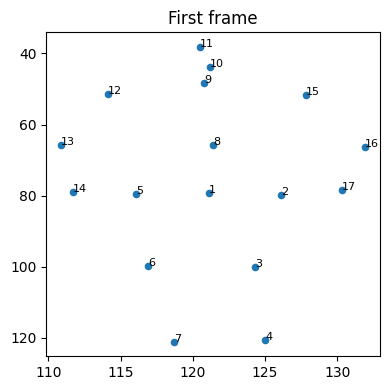

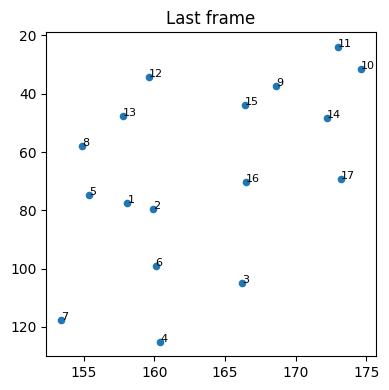

In [39]:
def plot_skeleton(xy, title=""):
    # xy: (17,2) -> simple scatter; connect a few plausible limbs if you want
    plt.figure(figsize=(4,4))
    plt.scatter(xy[:,0], xy[:,1], s=20)
    for i in range(xy.shape[0]):
        plt.text(xy[i,0], xy[i,1], str(i+1), fontsize=8)
    plt.gca().invert_yaxis()   # image coords usually have y down
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_skeleton(keypoints[0],  "First frame")
plot_skeleton(keypoints[-1], "Last frame")


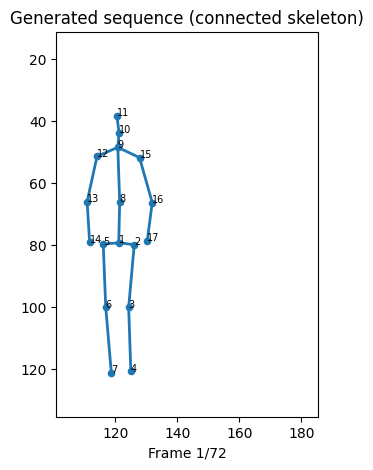

In [40]:
# Connected-skeleton animation for generated keypoints
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.collections import LineCollection

# render animations inline as JS
rc('animation', html='jshtml')

# your connections (0–16 indexing)
connections = [
    [0, 1], [1, 2], [2, 3],
    [0, 4], [4, 5], [5, 6],
    [0, 7], [7, 8], [8, 9], [9, 10],
    [8, 11], [11, 12], [12, 13],
    [8, 14], [14, 15], [15, 16],
]

T = keypoints.shape[0]
assert keypoints.shape == (T, 17, 2)

# fixed axes so the view doesn't jump
xmin, xmax = keypoints[:,:,0].min(), keypoints[:,:,0].max()
ymin, ymax = keypoints[:,:,1].min(), keypoints[:,:,1].max()

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Generated sequence (connected skeleton)")
ax.set_xlim(xmin-10, xmax+10)
ax.set_ylim(ymin-10, ymax+10)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()  # image coords

# draw first frame
pts0 = keypoints[0]
sc = ax.scatter(pts0[:,0], pts0[:,1], s=20)

# create a LineCollection for bones
segs0 = [pts0[[i,j], :] for (i,j) in connections]
lc = LineCollection(segs0, linewidths=2)
ax.add_collection(lc)

# (optional) tiny joint labels
labels = [ax.text(pts0[i,0], pts0[i,1], str(i+1), fontsize=7) for i in range(17)]

def update(t):
    pts = keypoints[t]
    sc.set_offsets(pts)
    # update bone segments
    segs = [pts[[i,j], :] for (i,j) in connections]
    lc.set_segments(segs)
    # update labels
    for i, txt in enumerate(labels):
        txt.set_position((pts[i,0], pts[i,1]))
    ax.set_xlabel(f"Frame {t+1}/{T}")
    return [sc, lc, *labels]

# ani = animation.FuncAnimation(fig, update, frames=T, interval=50, blit=False)
# ani  # displays inline in Jupyter
ani = animation.FuncAnimation(fig, update, frames=T, interval=333, blit=False)
ani  # displays inline in Jupyter

In [41]:
ani.save("generated_turn1.gif", writer=animation.PillowWriter(fps=20))